In [32]:
'''
Cleaning and merging yield curve, yield curve velocity, yield curve acceleration, 
PPI, PPI velocity, PPI acceleration, and Real GDP.
Initially I will define the start of a recession when Real GDP falls for 2 consecutive quarters,
and the end of recession when GDP rises for 2 consecutive quarters.
'''  

'\nCleaning and merging yield curve, yield curve velocity, yield curve acceleration, \nPPI, PPI velocity, PPI acceleration, and Real GDP.\nInitially I will define the start of a recession when Real GDP falls for 2 consecutive quarters,\nand the end of recession when GDP rises for 2 consecutive quarters.\n'

In [33]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

,DATE,GDPC1
0,1947-01-01,2034.450
1,1947-04-01,2029.024
2,1947-07-01,2024.834
3,1947-10-01,2056.508
4,1948-01-01,2087.442


,DATE,T10Y2Y
0,1976-06-01,0.68
1,1976-06-02,0.71
2,1976-06-03,0.70
3,1976-06-04,0.77
4,1976-06-07,0.79
5,1976-06-08,0.79
6,1976-06-09,0.82
7,1976-06-10,0.86
8,1976-06-11,0.83
9,1976-06-14,0.83


.
<class 'str'>
0.85
<class 'str'>
yc_clean:


C:\Users\Edmund\AppData\Local\Temp\ipykernel_8268\2640124709.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yc_clean['T10Y2Y'] = yc_clean['T10Y2Y'].astype(float) # convert to float after cleaning.


,DATE,T10Y2Y
0,1976-06-01,0.68
1,1976-06-02,0.71
2,1976-06-03,0.70
3,1976-06-04,0.77
4,1976-06-07,0.79
5,1976-06-08,0.79
6,1976-06-09,0.82
7,1976-06-10,0.86
8,1976-06-11,0.83
9,1976-06-14,0.83


,DATE,WPSID62
0,1947-04-01,30.7
1,1947-05-01,30.4
2,1947-06-01,30.6
3,1947-07-01,31.0
4,1947-08-01,31.6


C:\Users\Edmund\AppData\Local\Temp\ipykernel_8268\2640124709.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yc_clean['DATE'] = pd.to_datetime(yc_clean['DATE'], format='%Y-%m-%d')


,DATE,GDPC1
118,1976-07-01,5969.089
119,1976-10-01,6012.356
120,1977-01-01,6083.391
121,1977-04-01,6201.659
122,1977-07-01,6313.559


,DATE,T10Y2Y
0,1976-06-01,0.68
1,1976-06-02,0.71
2,1976-06-03,0.70
3,1976-06-04,0.77
4,1976-06-07,0.79


,DATE,WPSID62
350,1976-06-01,65.2
351,1976-07-01,64.8
352,1976-08-01,63.6
353,1976-09-01,63.4
354,1976-10-01,63.0


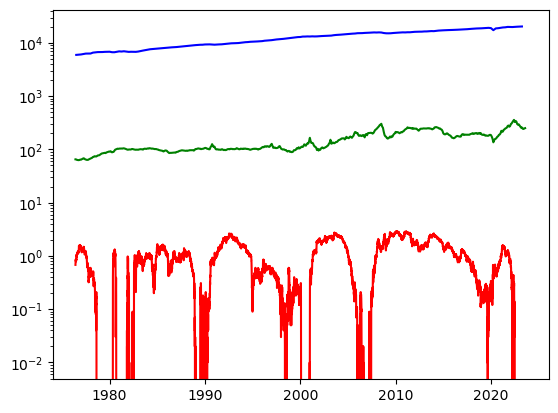

In [34]:
# Read in the data sets
gdp = pd.read_csv(r"C:\Users\Edmund\OMSA\MGT6203\group project\Team36_group_project\Data\Real_GDP_GDPC1.csv")
yc = pd.read_csv(r"C:\Users\Edmund\OMSA\MGT6203\group project\Team36_group_project\Data\yield_curve_T10Y2Y.csv")
# Using only seasonally adjusted PPI data.
PPI = pd.read_csv(r"C:\Users\Edmund\OMSA\MGT6203\group project\Team36_group_project\Data\PPI_Commodity_Intermediate_Demand_Unprocessed_Goods_seasonally_adjusted.csv")
# show format of the data
display(gdp.head(5))
display(yc.head(30))
print(yc['T10Y2Y'].loc[24])
print(type(yc['T10Y2Y'].loc[24]))
print(yc['T10Y2Y'].loc[23])
print(type(yc['T10Y2Y'].loc[23]))
yc_clean = yc[yc['T10Y2Y'] != '.'] # remove placeholders
yc_clean['T10Y2Y'] = yc_clean['T10Y2Y'].astype(float) # convert to float after cleaning.
print("yc_clean:")
display(yc_clean.head(30))
display(PPI.head(5))
# What data type do columns have?
# print(gdp['DATE'].dtype)
# print(gdp['GDPC1'].dtype)
# Convert 'DATE' columns to datetime type
gdp['DATE'] = pd.to_datetime(gdp['DATE'], format='%Y-%m-%d')
PPI['DATE'] = pd.to_datetime(PPI['DATE'], format='%Y-%m-%d')
yc_clean['DATE'] = pd.to_datetime(yc_clean['DATE'], format='%Y-%m-%d')
# get subset of PPI and GDP in the same date range as yield curve
gdp_76_plus = gdp[gdp['DATE'] >= yc_clean['DATE'].loc[0]]
PPI_76_plus = PPI[PPI['DATE'] >= yc_clean['DATE'].loc[0]]
display(gdp_76_plus.head(5))
display(yc_clean.head(5))
display(PPI_76_plus.head(5))

# plot everything in log scale:
plt.plot(gdp_76_plus['DATE'], gdp_76_plus['GDPC1'], color = 'blue')
plt.plot(PPI_76_plus['DATE'], PPI_76_plus['WPSID62'], color = 'green')
plt.plot(yc_clean['DATE'], yc_clean['T10Y2Y'], color = 'red')
plt.yscale('log')
plt.show()




# Generate yc velocity and acceleration

# Generate PPI velocity and acceleration

# display(gdp.head(5))
# print(gdp['DATE'].dtype)
# print(gdp['GDPC1'].dtype)
# # create velocity and acceleration for 
# print(gdp['DATE'].loc[0])
# print(type(gdp['DATE'].loc[0]))


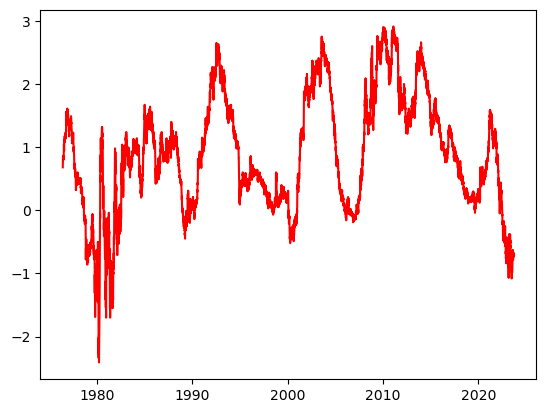

In [35]:
plt.plot(yc_clean['DATE'], yc_clean['T10Y2Y'], color = 'red')
plt.yscale('linear')
plt.show()

C:\Users\Edmund\AppData\Local\Temp\ipykernel_8268\3905252066.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yc_clean['trend'] = yc_ts.trend


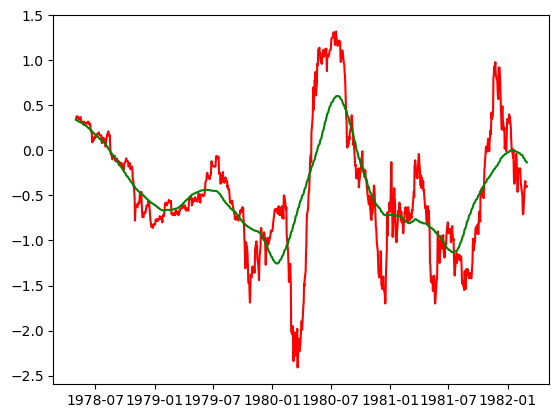

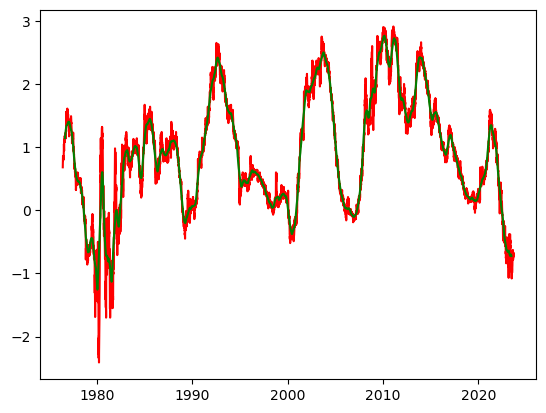

C:\Users\Edmund\AppData\Local\Temp\ipykernel_8268\3905252066.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yc_clean['velocity'] = np.gradient(yc_clean['trend'])
C:\Users\Edmund\AppData\Local\Temp\ipykernel_8268\3905252066.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yc_clean['acceleration'] = np.gradient(yc_clean['velocity'])


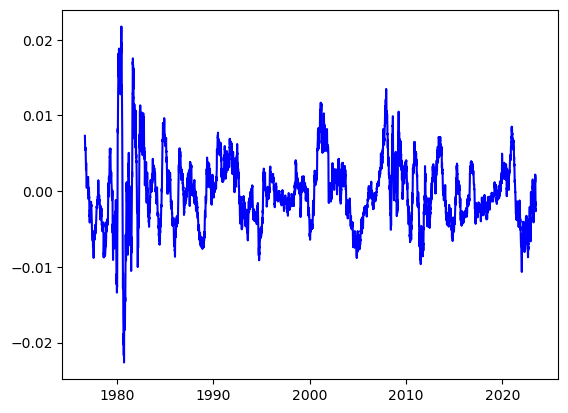

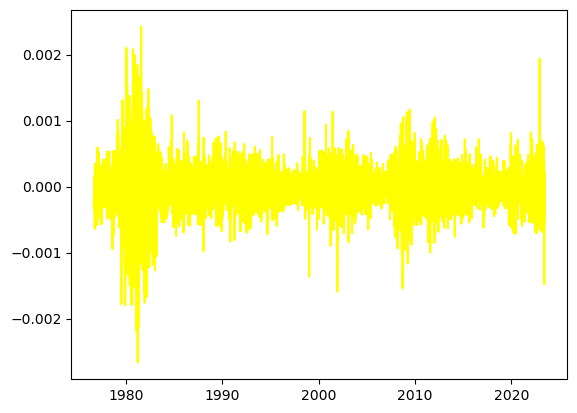

In [54]:
import statsmodels.tsa.api as tsa
# assume each point is a day for yc, and there is quarterly seasonality
yc_ts = tsa.seasonal_decompose(yc_clean['T10Y2Y'], model='additive', filt=None, period=120, two_sided=True, extrapolate_trend=0)
yc_clean['trend'] = yc_ts.trend

plt.plot(yc_clean['DATE'].loc[500:1500], yc_clean['T10Y2Y'].loc[500:1500], color = 'red')
plt.plot(yc_clean['DATE'].loc[500:1500], yc_clean['trend'].loc[500:1500], color = 'green')
plt.yscale('linear')
plt.show()

# period of 30 days looks pretty good.

plt.plot(yc_clean['DATE'], yc_clean['T10Y2Y'], color = 'red')
plt.plot(yc_clean['DATE'], yc_clean['trend'], color = 'green')
plt.yscale('linear')
plt.show()

# now let's generate velocity and acceleration features based on the exponentially smoothed data:

yc_clean['velocity'] = np.gradient(yc_clean['trend'])
yc_clean['acceleration'] = np.gradient(yc_clean['velocity'])

plt.plot(yc_clean['DATE'], yc_clean['velocity'], color = 'blue')
plt.show()

plt.plot(yc_clean['DATE'], yc_clean['acceleration'], color = 'yellow')
plt.show()



C:\Users\Edmund\AppData\Local\Temp\ipykernel_8268\1398801908.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yc_clean['velocity'] = np.gradient(yc_clean['T10Y2Y'])


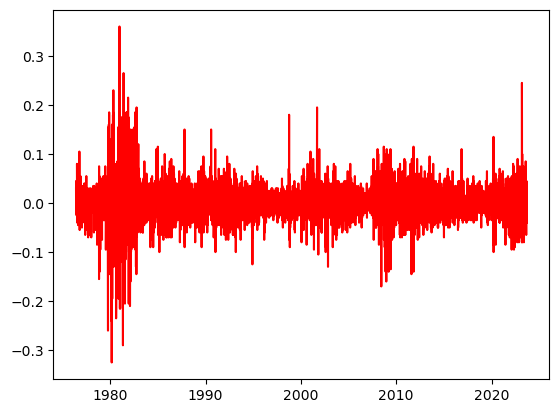

In [36]:
# What does the yc velocity look like?
yc_clean['velocity'] = np.gradient(yc_clean['T10Y2Y'])

plt.plot(yc_clean['DATE'], yc_clean['velocity'], color = 'red')
plt.yscale('linear')
plt.show()

C:\Users\Edmund\AppData\Local\Temp\ipykernel_8268\1254458987.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PPI_76_plus['trend'] = PPI_ts.trend


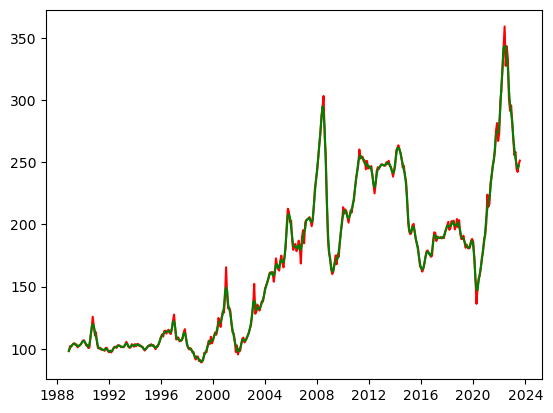

C:\Users\Edmund\AppData\Local\Temp\ipykernel_8268\1254458987.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PPI_76_plus['velocity'] = np.gradient(PPI_76_plus['WPSID62'])
C:\Users\Edmund\AppData\Local\Temp\ipykernel_8268\1254458987.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PPI_76_plus['acceleration'] = np.gradient(PPI_76_plus['velocity'])


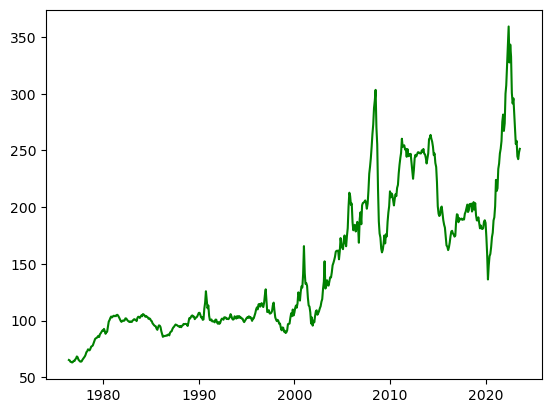

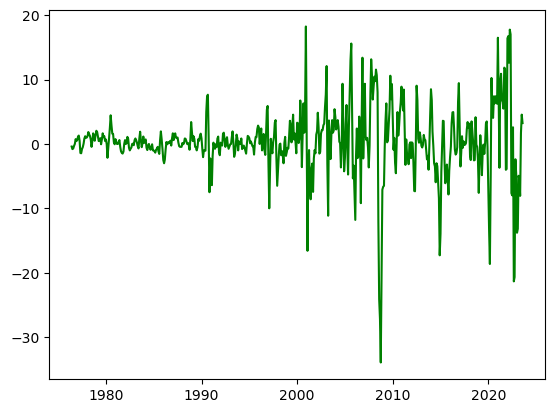

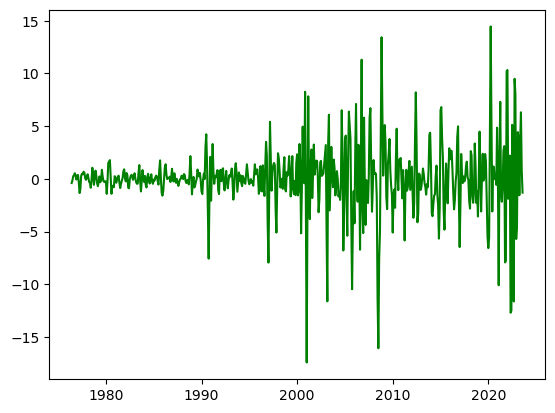

In [55]:
# Get velocity and acceleration for PPI
# assume monthly data and quarterly seasonality
PPI_ts = tsa.seasonal_decompose(PPI_76_plus['WPSID62'], model='additive', filt=None, period=3, two_sided=True, extrapolate_trend=0)
PPI_76_plus['trend'] = PPI_ts.trend

plt.plot(PPI_76_plus['DATE'].loc[500:1500], PPI_76_plus['WPSID62'].loc[500:1500], color = 'red')
plt.plot(PPI_76_plus['DATE'].loc[500:1500], PPI_76_plus['trend'].loc[500:1500], color = 'green')
plt.yscale('linear')
plt.show()

PPI_76_plus['velocity'] = np.gradient(PPI_76_plus['WPSID62'])
PPI_76_plus['acceleration'] = np.gradient(PPI_76_plus['velocity'])



plt.plot(PPI_76_plus['DATE'], PPI_76_plus['WPSID62'], color = 'green')
plt.show()
plt.plot(PPI_76_plus['DATE'], PPI_76_plus['velocity'], color = 'green')
plt.show()
plt.plot(PPI_76_plus['DATE'], PPI_76_plus['acceleration'], color = 'green')
plt.show()

In [ ]:
# Data is all here. Now I need to merge the dataframes. 
# I need to talk to the group about what timescale we want to use. I can interpolate from there.